In [1]:
#@title
# import required libraries

import pandas as pd # dataframes
import numpy as np #mathematical operations

# to visualise

import plotly.express as px # plotly
from wordcloud import WordCloud # wordclouds
import matplotlib.pyplot as plt #matplot
import seaborn as sns #seaborn
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Vectorisation

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Treating class imbalanced data

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# model building

from sklearn.model_selection import train_test_split

# algorithms

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# checking up with models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

<h3 style= "color:blue;"> Importing Data Set </h3>

In [2]:
# landing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# load your dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Research/Preprocessed.csv",index_col=[0])

In [13]:
# change both types into string
df['content'] = df['content'].astype('str')
df['fileclass'] = df['fileclass'].astype('str') 

In [14]:
unique_values = df['fileclass'].unique()
print(unique_values)

['ChildProtection' 'Cybersecurity' 'DataPrivacy' 'DataSystemsDevelopment'
 'DigitalFinance' 'DigitalInclusion' 'DigitalInformatioServices'
 'DigitalInfrastructure' 'DigitalLiteracy' 'DigitalServices' 'Egovernment'
 'Upskilling']


In [15]:
# Replace Cybersecurity value with 1
df.loc[df["fileclass"] == "DataSystemsDevelopment", "fileclass"] = 1
df.head(5)

,fileclass,content
0,ChildProtection,trend child sexual abuse material trend child ...
1,ChildProtection,covid remote eliminate female genital mutilati...
2,ChildProtection,journal medium subsequent selfharm followup ch...
3,ChildProtection,original ar sexual exploitation abuse child ph...
4,ChildProtection,covid implication protect child april covid pr...


In [16]:
# Replace other values with 0
df.loc[df["fileclass"] != 1, "fileclass"] = 0

# reorder the dataframe to get childprotection content to appear first
df = df.sort_values(by='fileclass', ascending=False)

df.head(5)

,fileclass,content
139,1,paper series informatics paper series discuss ...
117,1,software open design implementation electronic...
109,1,youth smallholder household untapped analysis ...
110,1,determine pmis optimal investment management h...
111,1,informatics paper series informatics paper ser...


In [17]:
# remove duplicates, leaving the first record
df = df.drop_duplicates(subset=['content'],keep="first")

In [18]:
# spread of text files after removing duplicates
# Count the number of items per group
group_counts = df.groupby("fileclass").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='fileclass', y='content',color="fileclass")

# Show the chart
fig.show()

<h3> Word Cloud </h3>

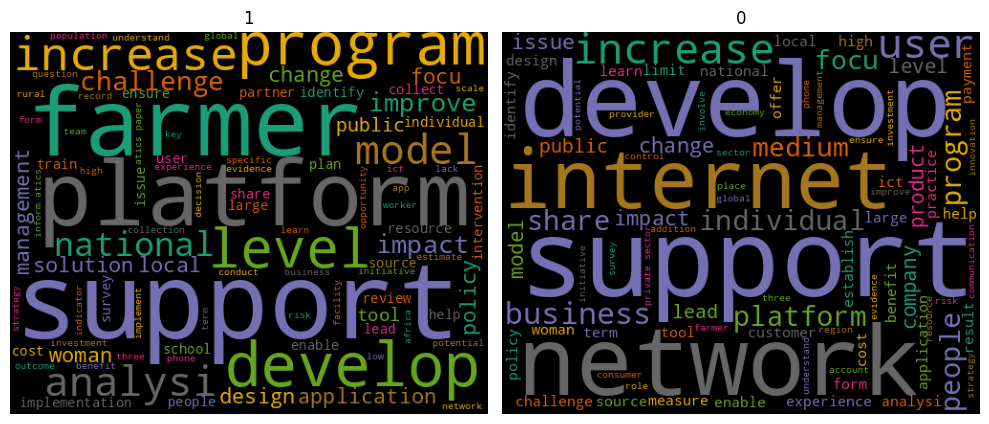

In [19]:
# word clouds based on intervention areas

# Get all the unique classes in the dataset
classes = df['fileclass'].unique()

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.ravel()

# Iterate through each class
for i, class_name in enumerate(classes):
    # Get all the text for the current class
    class_text = df[df['fileclass'] == class_name]['content'].str.cat(sep=' ')
    # Generate the wordcloud
    wordcloud = WordCloud(width = 500, height = 400, 
                colormap="Dark2",
                min_font_size = 10).generate(class_text) 
    # Plot the wordcloud
    axs[i].imshow(wordcloud) 
    axs[i].set_title(f"{class_name}") 
    axs[i].axis("off") 
fig.tight_layout()
plt.show()

As you can see the data set is class imbalanced.




<b> Now we have to vectorise our content column </b>

In [20]:
# vectorsing the content column
vectorizer = TfidfVectorizer(stop_words=None)
vectorized_df = vectorizer.fit_transform(df['content'])
# defining the y label
y = df['fileclass']
y=y.astype('int')
y=y.to_frame()

In [21]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
class_0_df = df[df['fileclass'] == 0]

# Concatenate the text data from class 0 samples into a single string
class_0_text = ' '.join(class_0_df['content'])

# Tokenize and filter the text data from class 0 samples
class_0_tokens = nltk.word_tokenize(class_0_text)

# Count the frequency of each word in class 0
class_0_word_freq = nltk.FreqDist(class_0_tokens)

# Filter the dataframe to include only class 1 samples
class_1_df = df[df['fileclass'] == 1]

# Concatenate the text data from class 1 samples into a single string
class_1_text = ' '.join(class_1_df['content'])

# Tokenize and filter the text data from class 1 samples
class_1_tokens = nltk.word_tokenize(class_1_text)

# Count the frequency of each word in class 1
class_1_word_freq = nltk.FreqDist(class_1_tokens)

# Get the keywords that are common in class 1 but not common in class 0
k = 10  # Specify the desired number of keywords
keywords = []

for word, frequency in class_1_word_freq.items():
    if word in class_0_word_freq:
        if frequency > class_0_word_freq[word]:
            keywords.append((word, frequency))

# Sort the keywords by frequency in descending order
keywords.sort(key=lambda x: x[1], reverse=True)


# Print the top keywords
for keyword, frequency in keywords[:k]:
    print(keyword, frequency)

district 1170
dag 1034
tb 834
mine 597
malaria 557
manchester 537
atics 473
ictag 422
sbcc 421
immunization 404


In [23]:
keywords= []

In [24]:
# Create binary features for each keyword
for keyword in keywords:
    df[keyword] = np.where(df['content'].str.contains(keyword), 1, 0)

In [25]:
from scipy.sparse import hstack

# Concatenate the binary features with the vectorized features
X = hstack([vectorized_df, df[keywords].values])

<h3 style= "color:blue;"> Defining train and test set </h3>

In [26]:
# train test split
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

<b> Finally we can get rid of class imbalanced data</b>

In [27]:
# treat class imbalanced data
ros = RandomOverSampler(random_state=1500)
X_trainro, Y_trainro = ros.fit_resample(X_train, Y_train)

In [28]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_trainru, Y_trainru = rus.fit_resample(X_train, Y_train)

<h3 style= "color:blue;"> Fit  Models </h3>

<h3> Random Forest</h3>

In [29]:
# fit the model
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, Y_train.values.ravel())

#make predictions
pred_rf = rf.predict(x_test)

#print accuracy
print("Accuracy %s" % accuracy_score(pred_rf,y_test))

Accuracy 0.8216216216216217


In [30]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       152
           1       0.00      0.00      0.00        33

    accuracy                           0.82       185
   macro avg       0.41      0.50      0.45       185
weighted avg       0.68      0.82      0.74       185



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<h3> Decision Trees </h3>

In [31]:
# fit the model
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, Y_train.values.ravel())

# make predictions
pred_dt = dt.predict(x_test)

# print accuracy 
print("Accuracy %s" % accuracy_score(pred_dt,y_test))

Accuracy 0.7891891891891892


In [32]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       152
           1       0.29      0.12      0.17        33

    accuracy                           0.79       185
   macro avg       0.56      0.53      0.52       185
weighted avg       0.73      0.79      0.75       185



<h3> Naive Bayes </h3>

In [35]:
# fit the model
nb = MultinomialNB()
nb.fit(X_trainru, Y_trainru.values.ravel())

# make predictions 
pred_nb = nb.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_nb,y_test))

Accuracy 0.6972972972972973


In [36]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       152
           1       0.31      0.55      0.39        33

    accuracy                           0.70       185
   macro avg       0.59      0.64      0.59       185
weighted avg       0.78      0.70      0.73       185



<h3> K-Nearest Neighbours </h3>

In [49]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_trainru, Y_trainru.values.ravel())

# make predictions
pred_knn = knn.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_knn,y_test))

Accuracy 0.6756756756756757


In [50]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78       152
           1       0.30      0.61      0.40        33

    accuracy                           0.68       185
   macro avg       0.59      0.65      0.59       185
weighted avg       0.78      0.68      0.71       185



<h3> Logistic Regression </h3>

In [39]:
# fit the model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, Y_train.values.ravel())

# make predictions
pred_lr = lr.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_lr,y_test))

Accuracy 0.7783783783783784


In [40]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       152
           1       0.30      0.18      0.23        33

    accuracy                           0.78       185
   macro avg       0.57      0.54      0.55       185
weighted avg       0.74      0.78      0.76       185



<h3> Ada Boost </h3>

In [41]:
# fit the model
ab = AdaBoostClassifier()
ab.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_ab = ab.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_ab,y_test))

Accuracy 0.7837837837837838


In [42]:
print(classification_report(y_test,pred_ab))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       152
           1       0.36      0.27      0.31        33

    accuracy                           0.78       185
   macro avg       0.60      0.58      0.59       185
weighted avg       0.76      0.78      0.77       185



<h3> SGD </h3>

In [43]:
# fit the model
sgd = SGDClassifier(class_weight='balanced')
sgd.fit(X_train, Y_train.values.ravel())

# make predictions
pred_sgd = sgd.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))

Accuracy 0.7945945945945946


In [44]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       152
           1       0.39      0.27      0.32        33

    accuracy                           0.79       185
   macro avg       0.62      0.59      0.60       185
weighted avg       0.77      0.79      0.78       185



<h3> Support Vectore Machine </h3>

In [45]:
# fit the model
svc = SVC(class_weight='balanced')
svc.fit(X_train, Y_train.values.ravel())

# make predictions
pred_svc = svc.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_svc,y_test))

Accuracy 0.827027027027027


In [46]:
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       152
           1       0.67      0.06      0.11        33

    accuracy                           0.83       185
   macro avg       0.75      0.53      0.51       185
weighted avg       0.80      0.83      0.76       185



<h3> Ensemble </h3>

In [47]:
from sklearn.ensemble import VotingClassifier

# Create instances of the SGDClassifier and RandomForestClassifier
sgd = SGDClassifier()
knn = KNeighborsClassifier()

# Create an instance of the VotingClassifier
ensemble = VotingClassifier(estimators=[('sgd', sgd), ('knn', knn)], voting='hard')

# Fit the VotingClassifier to the data
ensemble.fit(X_trainro, Y_trainro.values.ravel())

# Make predictions
pred_ensemble = ensemble.predict(x_test)

# Print accuracy
print("Accuracy %s" % accuracy_score(pred_ensemble, y_test))

Accuracy 0.8162162162162162


In [48]:
print(classification_report(y_test,pred_ensemble))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       152
           1       0.43      0.09      0.15        33

    accuracy                           0.82       185
   macro avg       0.63      0.53      0.52       185
weighted avg       0.76      0.82      0.76       185



<h3 style= "color:blue;"> Conclusion - SGD</h3>

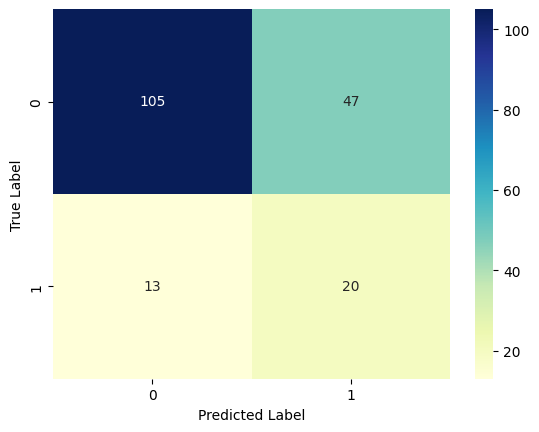

In [51]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_knn)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [52]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
joblib.dump(knn, '/content/drive/MyDrive/Colab Notebooks/Research/datasystems.pkl')

['/content/drive/MyDrive/Colab Notebooks/Research/datasystems.pkl']